In [1]:
import sys
from pathlib import Path

# Add the project root (one level up from notebooks/) to sys.path
sys.path.append(str(Path().resolve().parent))

import importlib
from spine_score.src import extract, dataset, model
from pathlib import Path
import os 
import zipfile
import matplotlib.pyplot as plt
import glob
import pydicom
import numpy as np
import nibabel as nib

In [2]:
# Updated extract.py:

import os
import zipfile
import pandas as pd
import shutil
from pathlib import Path
from typing import Optional

ZIP_PATH = "../data"                # Hard coded defualt for data
INTERIM_DIR = "../data/interim"     # Hard coded default

def extract_zip_files(input_file: str, output_path: str) -> None:
    """Extracts any zip files in the raw dataset into the interim directory.

    Args:
        raw_dir (str): Path to the raw dataset directory.
        interim_dir (str): Path to the interim directory where zip contents will be extracted.

    Returns:
        None
    """
    os.makedirs(output_path, exist_ok=True)
    
    with zipfile.ZipFile(input_file, "r") as zip:
        zip.extractall(output_path)
        
def extract_tsv_files(zip: str = ZIP_PATH, interim_dir: Path = INTERIM_DIR) -> pd.DataFrame:
    """Extracts and combines TSV metadata files from the raw dataset.

    Args:
        raw_dir (str): Path to the raw dataset directory.
        interim_dir (str): Path to the interim directory where combined metadata will be saved.

    Returns:
        Combined Dataframe
    """
    zip_file = zip + "/DukeCSpineSeg_structured.zip" # path to zip with tsv files

    # zip = zip + "structured.zip" # path to zip with tsv files
    
    extract_zip_files(zip_file, interim_dir)
    
    all_tsvs = []
    for root, _, files in os.walk(interim_dir):
        for f in files:
            if f.endswith(".tsv"):
                tsv_path = os.path.join(root, f)
                df = pd.read_csv(tsv_path, sep="\t")
                all_tsvs.append(df)

    
    combined_df = pd.concat(all_tsvs, ignore_index=True)
    print(f"Combined DataFrame shape: {combined_df.shape}")
    
    return combined_df


def extract_data(zip_path: str = ZIP_PATH, interim_dir: Path = INTERIM_DIR) -> None:
    """Copies MRI images, segmentation masks, and annotation files into interim folders.

    Args:
        raw_dir (str): Path to the raw dataset directory.
        interim_dir (str): Path to the interim directory where files will be copied.

    Returns:
        None
    """
    types = ["segmentation", "imaging_files", "annotation"]
    
    # loop through all zips and extract data 
    for t in types:
        zip_file = Path(zip_path) / f"DukeCSpineSeg_{t}.zip"
        # zip_file = zip_path + t + ".zip"
        output_dir = interim_dir / t
        extract_zip_files(zip_file, output_dir)
        
        print(f"Files in {zip_file} extracted.")

    

In [3]:
# Reloads modules (run for development update with the notebook)
# importlib.reload(extract) (Updated above)
importlib.reload(dataset)
importlib.reload(model)

<module 'spine_score.src.model' from 'C:\\Users\\Maxtw\\OneDrive\\Desktop\\Final Project 521\\aai-521-final-project\\spine_score\\src\\model.py'>

In [4]:
# df = extract.extract_tsv_files()
df = extract_tsv_files()

# Assuming combined_df is your DataFrame
print(list(df.columns))

Combined DataFrame shape: (25389, 79)
['type', 'submitter_id', 'md5sum', 'file_size', 'file_name', 'data_type', 'data_format', 'data_category', 'annotation_name', 'annotation_method', 'cases.submitter_id', 'case_ids', 'mr_series_files.submitter_id', 'imaging_studies.submitter_id', 'urls', 'datasets', 'age_at_index', 'age_at_index_gt89', 'country_of_residence', 'covid19_positive', 'ethnicity', 'gen3_linked_subjects_available', 'icu_indicator', 'index_event', 'linked_external_data', 'long_covid_diagnosis', 'race', 'sex', 'site_id', 'token_record_id', 'ventilator_indicator', 'treatment_info', 'zip', 'acl', 'storage_urls', 'study_uid', 'series_uid', 'instance_uid', 'modality', 'datasets.submitter_id', 'body_part_examined', 'days_to_study', 'image_data_modified', 'study_description', 'study_modality', 'study_year', 'study_year_shifted', 'age_at_imaging', 'age_at_imaging_gt89', 'angio_flag', 'contrast_bolus_agent', 'diffusion_b_value', 'diffusion_gradient_orientation', 'echo_number', 'echo_t

In [5]:
# extract data from the zip files downloaded
zip_path = "../data"
interim_dir = Path("../data/interim")

# extract.extract_data(zip_path, interim_dir)
extract_data(zip_path, interim_dir)

Files in ..\data\DukeCSpineSeg_segmentation.zip extracted.
Files in ..\data\DukeCSpineSeg_imaging_files.zip extracted.
Files in ..\data\DukeCSpineSeg_annotation.zip extracted.


In [6]:
# Extract all .dcm files from their nested zips to help with data loading later
# root folder containing zip files 
root_dir = "../data/interim/imaging_files/case_image"

for dirpath, dirnames, filenames in os.walk(root_dir):
    for file in filenames:
        if file.endswith(".zip"):
            zip_path = os.path.join(dirpath, file)
            # extract into the folder where the zip resides
            extract_to = dirpath
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(extract_to)
            print(f"Extracted {zip_path} to {extract_to}")

Extracted ../data/interim/imaging_files/case_image\593973-000001\1.2.826.0.1.3680043.10.474.593973.19\1.2.826.0.1.3680043.10.474.593973.20.zip to ../data/interim/imaging_files/case_image\593973-000001\1.2.826.0.1.3680043.10.474.593973.19
Extracted ../data/interim/imaging_files/case_image\593973-000001\1.2.826.0.1.3680043.10.474.593973.2\1.2.826.0.1.3680043.10.474.593973.3.zip to ../data/interim/imaging_files/case_image\593973-000001\1.2.826.0.1.3680043.10.474.593973.2
Extracted ../data/interim/imaging_files/case_image\593973-000002\1.2.826.0.1.3680043.10.474.593973.19\1.2.826.0.1.3680043.10.474.593973.20.zip to ../data/interim/imaging_files/case_image\593973-000002\1.2.826.0.1.3680043.10.474.593973.19
Extracted ../data/interim/imaging_files/case_image\593973-000003\1.2.826.0.1.3680043.10.474.593973.36\1.2.826.0.1.3680043.10.474.593973.37.zip to ../data/interim/imaging_files/case_image\593973-000003\1.2.826.0.1.3680043.10.474.593973.36
Extracted ../data/interim/imaging_files/case_image\

In [7]:
series = Path("../data/interim/imaging_files/case_image/593973-000001/1.2.826.0.1.3680043.10.474.593973.2/1.2.826.0.1.3680043.10.474.593973.3")

dcm_files = sorted(series.glob("*.dcm"))

print(f"Found {len(dcm_files)} DICOM slices:")
for f in dcm_files:
    print("  ", f.name)

Found 14 DICOM slices:
   1.2.826.0.1.3680043.10.474.593973.1.dcm
   1.2.826.0.1.3680043.10.474.593973.10.dcm
   1.2.826.0.1.3680043.10.474.593973.11.dcm
   1.2.826.0.1.3680043.10.474.593973.12.dcm
   1.2.826.0.1.3680043.10.474.593973.13.dcm
   1.2.826.0.1.3680043.10.474.593973.14.dcm
   1.2.826.0.1.3680043.10.474.593973.15.dcm
   1.2.826.0.1.3680043.10.474.593973.16.dcm
   1.2.826.0.1.3680043.10.474.593973.17.dcm
   1.2.826.0.1.3680043.10.474.593973.5.dcm
   1.2.826.0.1.3680043.10.474.593973.6.dcm
   1.2.826.0.1.3680043.10.474.593973.7.dcm
   1.2.826.0.1.3680043.10.474.593973.8.dcm
   1.2.826.0.1.3680043.10.474.593973.9.dcm


As seen above, There are 14 total slices per patient.  
However, there is only one ground truth mask file (seen in segmentation folder). Thus, it is a 3d mask.

Lets try to visualize a slice (see below)

Found DICOM series at:
..\data\interim\imaging_files\case_image\593973-000001\1.2.826.0.1.3680043.10.474.593973.19\1.2.826.0.1.3680043.10.474.593973.20
Loaded 14 slices
Image shape (slices, H, W): (14, 512, 512)

Metadata:
  Series UID: 1.2.826.0.1.3680043.10.474.593973.20
  Modality: MR
  Pixel Spacing: [0.4297, 0.4297]
  Slice Thickness: 3


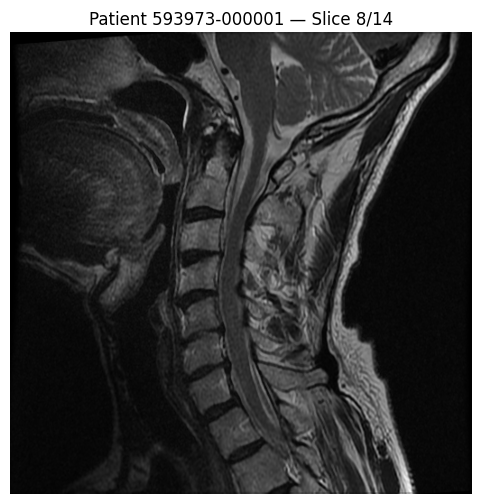

In [9]:
def load_patient_series(root):
    """
    Loads all DICOM slices in the nested series folder.
    Returns a volume (numpy array) and sorted list of dicoms.
    """
    root = Path(root)

    # Find all DICOMs recursively
    dcm_files = sorted(root.rglob("*.dcm"))

    if len(dcm_files) == 0:
        raise ValueError(f"No DICOM files found under {root}")

    # Read all slices
    dicoms = [pydicom.dcmread(str(f)) for f in dcm_files]

    # Sort slices by InstanceNumber (more reliable than filename)
    dicoms = sorted(dicoms, key=lambda d: int(d.InstanceNumber))

    # Build numpy volume
    volume = np.stack([d.pixel_array for d in dicoms], axis=0)

    return volume, dicoms


# ---- Load This Patient ----

patient_path = Path(
    "../data/interim/imaging_files/case_image/593973-000001"
)

# Automatically find the deepest folder with DICOMs
series_path = None
for folder in patient_path.rglob("*"):
    if any(folder.glob("*.dcm")):
        series_path = folder
        break

if series_path is None:
    raise RuntimeError("Could not locate DICOM series folder")

print(f"Found DICOM series at:\n{series_path}")

volume, dicoms = load_patient_series(series_path)

# ---- Display Information ----
print(f"Loaded {len(dicoms)} slices")
print("Image shape (slices, H, W):", volume.shape)

first = dicoms[0]
print("\nMetadata:")
print("  Series UID:", first.SeriesInstanceUID)
print("  Modality:", first.Modality)
print("  Pixel Spacing:", first.PixelSpacing)
print("  Slice Thickness:", first.SliceThickness)


# ---- Show Middle Slice ----
mid = volume.shape[0] // 2

plt.figure(figsize=(6,6))
plt.imshow(volume[mid], cmap="gray")
plt.title(f"Patient 593973-000001 — Slice {mid+1}/{volume.shape[0]}")
plt.axis("off")
plt.show()


Each slice has metadata along with it (see below for a list of them)

Modality: MR
SeriesInstanceUID: 1.2.826.0.1.3680043.10.474.593973.3
InstanceNumber: 8
ImagePositionPatient: [-7.44758, -135.757, -30.9355]
ImageOrientationPatient: [-0.00007, 0.90957, 0.41556, 0.04532, 0.41513, -0.90863]
PixelSpacing: [0.4297, 0.4297]
SliceThickness: 3
SpacingBetweenSlices: 4
Manufacturer: GE MEDICAL SYSTEMS
SeriesDescription: sag t2


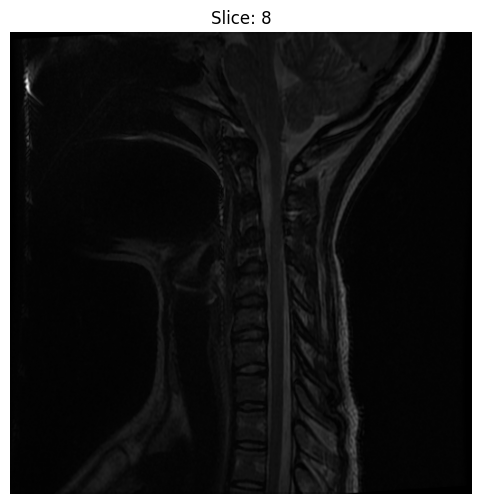

In [10]:
dcm = pydicom.dcmread("../data/interim/imaging_files/case_image/" \
"593973-000001/1.2.826.0.1.3680043.10.474.593973.2/1.2.826.0.1.3680043.10.474.593973.3"
"/1.2.826.0.1.3680043.10.474.593973.11.dcm")

fields = [
    "Modality",                 # Type of Scan (MR = Magnetic Resonance Imaging)
    "SeriesInstanceUID",        # ID unique to global files
    "InstanceNumber",           # slice index assigned by the scanner
    # This is the 3D coordinate of the top-left corner of the slice in the patient’s 
    # reference system. (below)
    "ImagePositionPatient",     
    "ImageOrientationPatient",  # Defines the 3D orientation vectors of the image axes
    "PixelSpacing",             # Real-world physical spacing (mm) between pixels in-plane (mm)
    "SliceThickness",           # Physical thickness (in mm) of each slice
    "SpacingBetweenSlices",     # The distance between slice centers
    "Manufacturer",             # The MRI scanner vendor
    "SeriesDescription",        # Human-readable name given by the technologist
]

for f in fields:
    value = getattr(dcm, f, "N/A")
    print(f"{f}: {value}")

# Full path to your DICOM file
dcm_path = (
    "../data/interim/imaging_files/case_image/"
    "593973-000001/1.2.826.0.1.3680043.10.474.593973.2/"
    "1.2.826.0.1.3680043.10.474.593973.3/"
    "1.2.826.0.1.3680043.10.474.593973.11.dcm"
)

# Load the DICOM
ds = pydicom.dcmread(dcm_path)

# Extract pixel data (as numpy array)
img = ds.pixel_array

# Display it
plt.figure(figsize=(6,6))
plt.imshow(img, cmap="gray")
plt.title(f"Slice: {ds.InstanceNumber}")
plt.axis("off")
plt.show()

Next, is the mask only. Lets visualize that next.

Mask volume shape: (512, 512, 14)


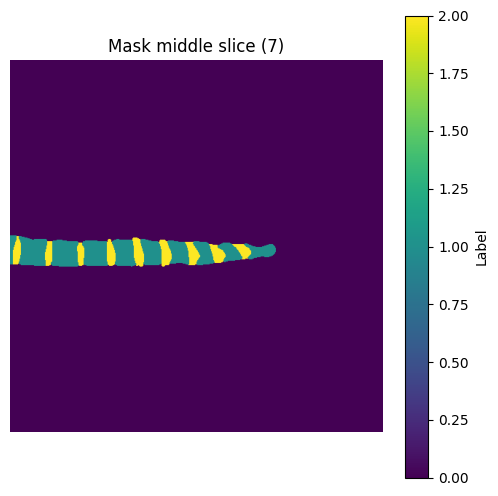

In [11]:
# Path to the mask file
mask_file = Path("../data/interim/segmentation/593973-000001_Study-MR-1_Series-22_SEG.nii.gz")

# Load the NIfTI file
mask_nii = nib.load(mask_file)
mask_volume = mask_nii.get_fdata()  # shape: (H, W, D)
print("Mask volume shape:", mask_volume.shape)

# Show middle slice along depth
mid = mask_volume.shape[2] // 2

plt.figure(figsize=(6,6))
plt.imshow(mask_volume[:, :, mid], cmap="viridis")  # or use 'Reds', 'Blues', etc. for specific classes
plt.title(f"Mask middle slice ({mid})")
plt.axis("off")
plt.colorbar(label="Label")
plt.show()

The next cell matches the appropriate slices with its own mask.

In [ ]:
# # Matching Study Ids to ensure that segmentation and images are mapped appropriately 
# # DICOM root after extraction
# dicom_root = "../data/interim/imaging_files/case_image"

# # Segmentation root
# mask_root = "../data/interim/segmentation"

# # Map study_id -> DICOM folder
# dicom_map = {}
# for folder in glob.glob(os.path.join(dicom_root, "*")):  # first level
#     study_id = os.path.basename(folder)
#     # pick the deepest folder containing DICOMs
#     dcm_subfolders = [f for f in glob.glob(os.path.join(folder, "**"), recursive=True) if os.path.isdir(f) and len(glob.glob(os.path.join(f, "*.dcm"))) > 0]
#     if dcm_subfolders:
#         dicom_map[study_id] = dcm_subfolders[0]
        
# # Map study_id -> mask file
# mask_map = {}
# for mask_file in glob.glob(os.path.join(mask_root, "*_SEG.nii.gz")):
#     study_id = os.path.basename(mask_file).split("_")[0]
#     mask_map[study_id] = mask_file

# # Only keep the studies that have both DICOMs and masks
# dataset_entries = [(dicom_map[s], mask_map[s]) for s in dicom_map if s in mask_map]

# print(f"Found {len(dataset_entries)} paired DICOMs and masks")
# print(f"Example entry: {dataset_entries[0]}")

I had to change the above cell because some patients have multiple spinal masks and images.

In [12]:
import os, glob, re
import pydicom
from collections import defaultdict

# -------------------------------
# 1. Paths
# -------------------------------
dicom_root = "../data/interim/imaging_files/case_image"
mask_root  = "../data/interim/segmentation"

# -------------------------------
# 2. Build DICOM metadata map
# -------------------------------
dicom_meta = defaultdict(list)

print("Scanning DICOM folders...\n")

for patient_folder in glob.glob(os.path.join(dicom_root, "*")):
    patient_id = os.path.basename(patient_folder)

    # All folders containing *.dcm files
    series_dirs = [
        d for d in glob.glob(os.path.join(patient_folder, "**"), recursive=True)
        if os.path.isdir(d) and len(glob.glob(os.path.join(d, "*.dcm"))) > 0
    ]

    for sd in series_dirs:
        example_file = glob.glob(os.path.join(sd, "*.dcm"))[0]

        try:
            ds = pydicom.dcmread(example_file, stop_before_pixels=True)

            dicom_meta[patient_id].append({
                "folder": sd,
                "SeriesInstanceUID": getattr(ds, "SeriesInstanceUID", None),
                "SeriesNumber":     getattr(ds, "SeriesNumber", None),
                "StudyInstanceUID": getattr(ds, "StudyInstanceUID", None),
            })
        except Exception as e:
            print(f"Failed reading {example_file}: {e}")

# -------------------------------
# 3. Build Mask metadata map
# -------------------------------
mask_meta = defaultdict(list)

print("\nScanning mask files...\n")

mask_pattern = re.compile(
    r"(\d+-\d+)_Study-[A-Za-z]+-(\d+)_Series-(\d+)_SEG\.nii\.gz"
)

for mask_file in glob.glob(os.path.join(mask_root, "*.nii.gz")):
    base = os.path.basename(mask_file)

    m = mask_pattern.match(base)
    if m:
        pid, study_num, series_num = m.groups()

        mask_meta[pid].append({
            "file": mask_file,
            "StudyNumber": int(study_num),
            "SeriesNumber": int(series_num)
        })
    else:
        print(f"Could not parse mask name: {mask_file}")

# -------------------------------
# 4. Match masks ↔ DICOM series
# -------------------------------
dataset_entries = []

print("\nMatching masks to DICOM series...\n")

for pid in mask_meta:
    print(f"Patient {pid}:")
    dcm_list = dicom_meta.get(pid, [])

    for mask in mask_meta[pid]:
        target_series = mask["SeriesNumber"]

        match = None
        for dcm in dcm_list:
            if dcm["SeriesNumber"] == target_series:
                match = dcm
                break

        if match:
            dataset_entries.append((pid, match["folder"], mask["file"]))
            print(f"  MATCH: Series {target_series} →")
            print(f"      Image: {match['folder']}")
            print(f"      Mask:  {mask['file']}")
        else:
            print(f"  NO MATCH FOR mask: {mask['file']} (Series {target_series})")

# -------------------------------
# 5. Summary
# -------------------------------
print("\n====================")
print("SUMMARY")
print("====================")
print(f"Total matched pairs: {len(dataset_entries)}\n")

if len(dataset_entries) > 0:
    print("Example pair:")
    print(dataset_entries[0])


Scanning DICOM folders...


Scanning mask files...


Matching masks to DICOM series...

Patient 593973-000001:
  MATCH: Series 22 →
      Image: ../data/interim/imaging_files/case_image\593973-000001\1.2.826.0.1.3680043.10.474.593973.2\1.2.826.0.1.3680043.10.474.593973.3
      Mask:  ../data/interim/segmentation\593973-000001_Study-MR-1_Series-22_SEG.nii.gz
Patient 593973-000002:
  MATCH: Series 3 →
      Image: ../data/interim/imaging_files/case_image\593973-000002\1.2.826.0.1.3680043.10.474.593973.19\1.2.826.0.1.3680043.10.474.593973.20
      Mask:  ../data/interim/segmentation\593973-000002_Study-MR-2_Series-3_SEG.nii.gz
Patient 593973-000003:
  MATCH: Series 3 →
      Image: ../data/interim/imaging_files/case_image\593973-000003\1.2.826.0.1.3680043.10.474.593973.36\1.2.826.0.1.3680043.10.474.593973.37
      Mask:  ../data/interim/segmentation\593973-000003_Study-MR-3_Series-3_SEG.nii.gz
Patient 593973-000004:
  MATCH: Series 3 →
      Image: ../data/interim/imaging_files/case_image

Now lets try overlapping them (see below)

Search folder: ..\data\interim\imaging_files\case_image\593973-000001\1.2.826.0.1.3680043.10.474.593973.2\1.2.826.0.1.3680043.10.474.593973.3
Found DICOMs: 14
DICOM volume shape: (512, 512, 14)
Mask volume shape: (512, 512, 14)


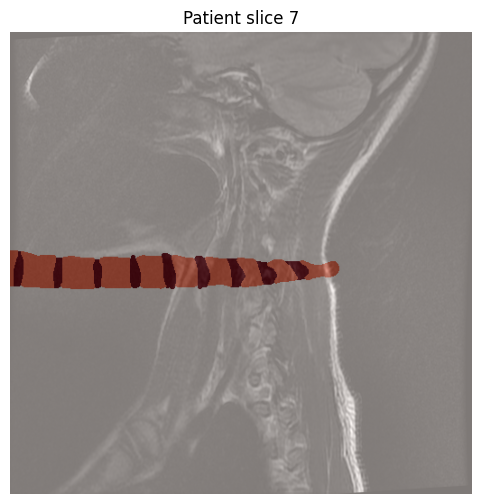

In [16]:
# Pick the first patient as an example
patient_id, dicom_folder, mask_file = dataset_entries[0]

# ----------------------------
# Load DICOM slices into a 3D numpy array
# ----------------------------
dicom_folder = Path(dicom_folder)

# Recursively find all .dcm files
dcm_files = sorted(
    f for f in dicom_folder.rglob("*.dcm")
    if f.is_file()
)
print("Search folder:", dicom_folder)
print("Found DICOMs:", len(dcm_files))

slices = [pydicom.dcmread(f).pixel_array for f in dcm_files]
img_volume = np.stack(slices, axis=-1)  # shape: (H, W, slices)

print("DICOM volume shape:", img_volume.shape)

# ----------------------------
# Load the segmentation mask (NIfTI)
# ----------------------------
mask_nii = nib.load(mask_file)
mask_volume = mask_nii.get_fdata()
print("Mask volume shape:", mask_volume.shape)

# ----------------------------
# Display the middle slice with overlay
# ----------------------------
mid = img_volume.shape[2] // 2

plt.figure(figsize=(6,6))
plt.imshow(img_volume[:, :, mid], cmap="gray")
plt.imshow(mask_volume[:, :, mid], cmap="Reds", alpha=0.5)
plt.axis("off")
plt.title(f"Patient slice {mid}")
plt.show()


Since the mask is not lining up properly, we must rotate and flip it to make it match.

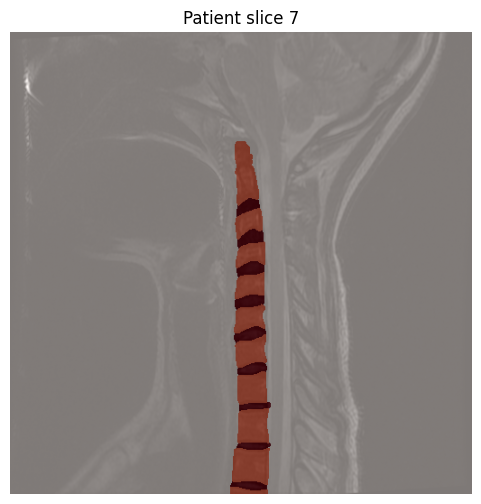

In [19]:
def load_patient_volume(entry, slice_to_show=None, visualize=True):
    """
    Loads a patient's MRI volume and segmentation mask, aligns the mask,
    and optionally displays a slice overlay.
    
    Args:
        entry (tuple): (dicom_folder, mask_file) from dataset_entries
        slice_to_show (int, optional): index of slice to display. Defaults to middle slice.
        visualize (bool): whether to display the overlay slice.
        
    Returns:
        img_volume (np.ndarray): DICOM volume (H, W, slices)
        mask_volume_aligned (np.ndarray): aligned mask volume (H, W, slices)
    """
    
    patient_id, dicom_folder, mask_file = entry
    dicom_folder = Path(dicom_folder)

    # ----------------------------
    # Load DICOM slices
    # ----------------------------
    dcm_files = sorted(
        dicom_folder.glob("*.dcm"),
        key=lambda f: int(pydicom.dcmread(f).InstanceNumber)
    )
    slices = [pydicom.dcmread(f).pixel_array for f in dcm_files]
    img_volume = np.stack(slices, axis=-1)  # shape: (H, W, slices)
    
    # ----------------------------
    # Load mask
    # ----------------------------
    mask_nii = nib.load(mask_file)
    mask_volume = mask_nii.get_fdata()
    
    # ----------------------------
    # Align mask (rotate + horizontal flip)
    # ----------------------------
    mask_volume_aligned = np.rot90(mask_volume, k=1)
    mask_volume_aligned = np.flip(mask_volume_aligned, axis=2)
    
    # ----------------------------
    # Optional visualization
    # ----------------------------
    if visualize:
        mid = slice_to_show if slice_to_show is not None else img_volume.shape[2] // 2
        plt.figure(figsize=(6,6))
        plt.imshow(img_volume[:, :, mid], cmap="gray")
        plt.imshow(mask_volume_aligned[:, :, mid], cmap="Reds", alpha=0.5)
        plt.axis("off")
        plt.title(f"Patient slice {mid}")
        plt.show()
    
    return img_volume, mask_volume_aligned

# Load and visualize the first patient
img_vol, mask_vol = load_patient_volume(dataset_entries[0], visualize=True)


In [25]:
# pick an example entry
patient_id, dicom_folder, mask_path = dataset_entries[0]

# raw load
img_vol = dataset.load_dicom_volume(dicom_folder)   # (H,W,D)
mask_raw = dataset.load_mask(mask_path)             # (H,W,D)

# aligned using your helper (rotation+flip)
img_vol2, mask_aligned = load_patient_volume((patient_id, dicom_folder, mask_path), visualize=False)

print("=== RAW / ALIGNED CHECK ===")
print("dicom_folder:", dicom_folder)
print("mask_path:", mask_path)
print("img_vol shape:", img_vol.shape, " dtype:", img_vol.dtype, " min/max:", img_vol.min(), img_vol.max())
print("mask_raw shape:", mask_raw.shape, " dtype:", mask_raw.dtype, " unique:", np.unique(mask_raw))
print("img_vol2 shape (load_patient_volume):", img_vol2.shape)
print("mask_aligned shape:", mask_aligned.shape, " unique:", np.unique(mask_aligned), " dtype:", mask_aligned.dtype)


=== RAW / ALIGNED CHECK ===
dicom_folder: ../data/interim/imaging_files/case_image\593973-000001\1.2.826.0.1.3680043.10.474.593973.2\1.2.826.0.1.3680043.10.474.593973.3
mask_path: ../data/interim/segmentation\593973-000001_Study-MR-1_Series-22_SEG.nii.gz
img_vol shape: (512, 512, 14)  dtype: float32  min/max: 0.0 5906.0
mask_raw shape: (512, 512, 14)  dtype: uint8  unique: [0 1 2]
img_vol2 shape (load_patient_volume): (512, 512, 14)
mask_aligned shape: (512, 512, 14)  unique: [0. 1. 2.]  dtype: float64


Now lets visualize the entire volume using a gif by iterating through each slice paired with its ground truth mask.

Saved GIF to ../gifs\patient_0.gif


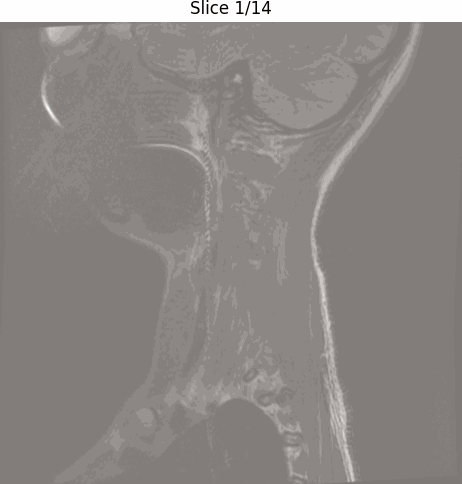

In [26]:
import os
from IPython.display import Image, display
import imageio
import matplotlib.pyplot as plt
from io import BytesIO

def create_and_display_patient_gif(img_volume, mask_volume, filename="patient.gif", delay=0.3):
    """
    Creates a looping GIF of a patient's MRI volume with overlayed mask,
    saves it to ../gifs, and displays inline in the notebook.

    Args:
        img_volume (np.ndarray): DICOM volume (H, W, slices)
        mask_volume (np.ndarray): aligned mask volume (H, W, slices)
        filename (str): name of the GIF file to save
        delay (float): seconds per frame
    """
    # Ensure gifs folder exists
    save_dir = "../gifs"
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, filename)

    frames = []
    num_slices = img_volume.shape[2]

    for i in range(num_slices):
        fig, ax = plt.subplots(figsize=(6,6))
        ax.imshow(img_volume[:, :, i], cmap="gray")
        ax.imshow(mask_volume[:, :, i], cmap="Reds", alpha=0.5)
        ax.axis("off")
        ax.set_title(f"Slice {i+1}/{num_slices}")

        buf = BytesIO()
        fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
        buf.seek(0)
        frame = imageio.v2.imread(buf)
        frames.append(frame)
        buf.close()
        plt.close(fig)

    # Save GIF (infinite loop)
    imageio.mimsave(save_path, frames, duration=delay, loop=0)
    print(f"Saved GIF to {save_path}")

    # Display GIF inline in notebook
    display(Image(filename=save_path))

img_vol, mask_vol = load_patient_volume(dataset_entries[0], visualize=False)
create_and_display_patient_gif(img_vol, mask_vol, filename="patient_0.gif", delay=0.3)
